In [11]:
import numpy as np
import scipy.linalg
from scipy.stats import ortho_group
from scipy.io import loadmat
from localizer import Localizer
import psi4
from iodata import load_one, dump_one

#https://github.com/molmod/molmod
from molmod.units import angstrom, debye

import matplotlib.pyplot as plt
import json

#importing the QM7 database
data = dict(loadmat('../molecule_geometries/qm7.mat'))
Z = data['Z'] # numbers
R = data['R']/angstrom # positions in angstrom

# Molecule order: H2O,CO2,HCN,Acetonitrile,H2SO4,Benzene,Diborane
numbers = np.load('../molecule_geometries/nuclei_numbers.npy')
positions = np.load('../molecule_geometries/positions.npy')

In [2]:
loc = Localizer(Z[0],R[0],0)

Psi4 Model initiated with method scf and basis set 6-311ppg_d_p_


In [2]:
loc = Localizer(numbers[4],positions[4])

Psi4 Model initiated with method scf and basis set 6-311ppg_d_p_


In [33]:
loc = Localizer(numbers[5],positions[5])

Psi4 Model initiated with method scf and basis set 6-311ppg_d_p_


In [8]:
loc.set_scheme('FB')
loc.scheme

['FB', 1.0]

In [12]:
loc.set_scheme('V3')
loc.scheme

['V3', 1.0]

In [23]:
loc.set_scheme('V4')
loc.scheme

['V4', 1.0]

In [34]:
loc.optimize_line_search(nsteps=1000, psi4_guess=False, save_iteration=15)

Optimizing cost function: FB
Convergence: norm of riemann gradient below 10^-5


True

Text(0, 0.5, '$norm(\\mathbf{G}_k)$')

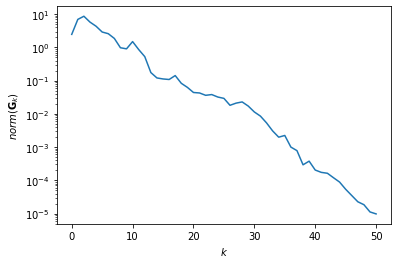

In [40]:
plt.plot(loc.conv_hist[np.where(loc.conv_hist != 0.)])
plt.yscale('log')
plt.xlabel('$k$')
plt.ylabel('$norm(\mathbf{G}_k)$')
# plt.savefig('norm_GCPR')

Text(0, 0.5, '$\\mu$')

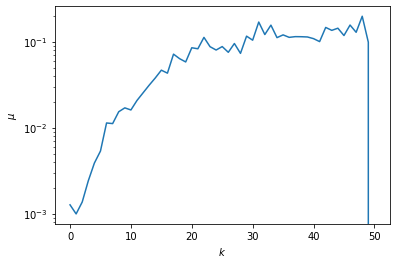

In [6]:
plt.plot(loc.step_hist[np.where(loc.conv_hist != 0.)])
plt.yscale('log')
plt.xlabel('$k$')
plt.ylabel('$\mu$')
# plt.savefig('norm_GCPR')

In [5]:
loc.compare_quadrupole()

array([[ 2.98160287e-05, -5.30001466e-05, -1.80407252e-04],
       [-5.30001466e-05,  7.36099922e-05, -2.54815121e-04],
       [-1.80407252e-04, -2.54815121e-04, -1.03426021e-04]])

In [6]:
loc.V4_cost(loc.W)

DeviceArray(-6.9366432e-07, dtype=float64)

In [29]:
np.array(range(1,5))

array([1, 2, 3, 4])

In [13]:
test_dict = {'CompareQuad': loc.compare_quadrupole().tolist(),
             'TotalQuad' : loc.total_quadrupole.tolist(),
             'LocalQuad' : loc.total_loc_quadrupole.tolist()}

In [16]:
test_list = [test_dict, test_dict, test_dict]

In [19]:
with open('test.json', 'w') as fout:
    json.dump(test_list, fout)
fout.close()

In [20]:
with open('test.json', 'r') as read_file:
    new_test_list = json.load(read_file)

In [25]:
new_test_list[0]['CompareQuad'] = loc.compare_quadrupole().tolist()

In [26]:
new_test_list[0]['CompareQuad']

[[-0.0011216863234926322, -0.001473671466924481, -0.0017759644940416666],
 [-0.001473671466924481, 0.0005017155352544655, 0.00033984305070364445],
 [-0.0017759644940416666, 0.00033984305070364445, 0.0006199707882355021]]

In [13]:
loc.compare_quadrupole()

array([[-3.90901169e-01,  6.26238439e-05,  1.16020805e-04],
       [ 6.26238439e-05,  1.95915017e-01, -9.49339634e-05],
       [ 1.16020805e-04, -9.49339634e-05,  1.94986152e-01]])

In [14]:
loc.V4_cost(loc.W)

DeviceArray(-0.73073785, dtype=float64)

In [15]:
loc.compare_quadrupole()

array([[-5.38752474e-01, -5.80421280e-05,  1.95854146e-05],
       [-5.80421280e-05,  2.69256583e-01,  7.88800924e-05],
       [ 1.95854146e-05,  7.88800924e-05,  2.69495891e-01]])

In [16]:
loc.V4_cost(loc.W)

DeviceArray(-1.38805076, dtype=float64)

In [4]:
loc.write_centers()

In [5]:
loc.write_orbitals()

## Second attempt using molden files

In [ ]:
psi4.molden(loc.model.wavefunction,'methane.molden')

In [ ]:
methane = load_one('methane.molden')
methane_mo = methane.mo
molden_C_occ = methane_mo.coeffs
molden_C_occ[:,:loc.N_occ] = loc.L_occ
methane_mo.coeffs = molden_C_occ
dump_one(methane, 'methane_test.fchk')

## Plotting the polynomial approximation

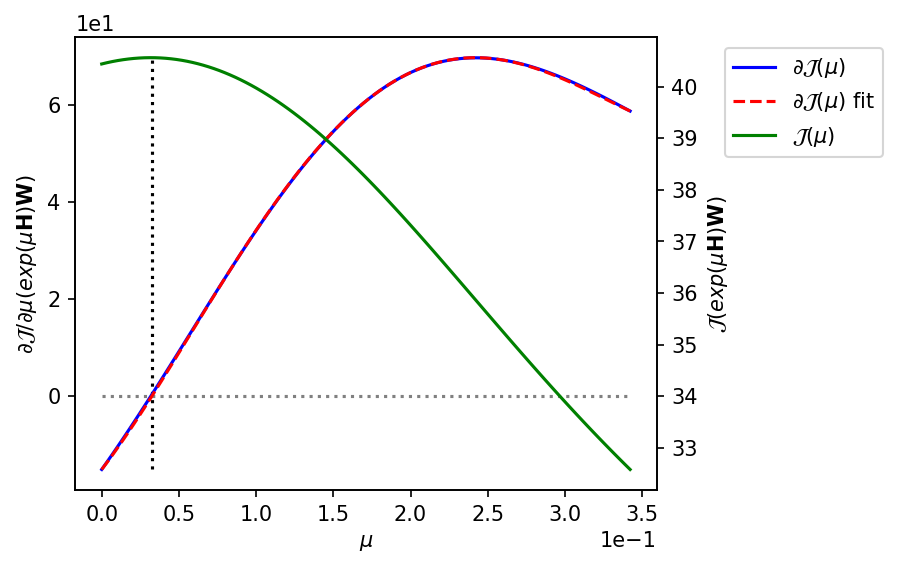

In [18]:
mu = np.linspace(0,loc.iteration_hist['MuMax'], 100)
dJ_mu = np.zeros((100))
J_mu = np.zeros((100))

H = loc.iteration_hist['H']
W = loc.iteration_hist['W']

for i in range(100):
    R = scipy.linalg.expm(mu[i]*H)
    J_mu[i] = np.array(loc.cost_function(np.dot(R,W)))
    inter_grad = np.array(loc.cost_grad(np.dot(R,W)))
    dJ_mu[i] = -2*np.einsum('ij,kj,lk,il',inter_grad, W, R, H)

dJ_mu_fit = np.polynomial.polynomial.polyval(mu, np.flip(loc.iteration_hist['PolyCoeffs']))

fig, ax = plt.subplots(1, 1, figsize=(5,4), squeeze=False, dpi=150)

ax = ax[0][0]
lns1 = ax.plot(mu, dJ_mu, color='b', label='$\partial\mathcal{J}(\mu)$')
lns2 = ax.plot(mu, dJ_mu_fit, linestyle='--', color='r', label='$\partial\mathcal{J}(\mu)$ fit')
ax.vlines(np.real(loc.iteration_hist['Root']), np.min(dJ_mu), np.max(dJ_mu), linestyle='dotted', color='k')
ax.hlines(0, np.min(mu), np.max(mu), linestyle='dotted', color='gray')
ax.ticklabel_format(axis='both', style='scientific', scilimits=(0,0))
ax.set_ylabel('$\partial \mathcal{J}/\partial \mu (exp(\mu\mathbf{H})\mathbf{W})$')
ax.set_xlabel('$\mu$')
ax.legend()

ax2 = ax.twinx()
lns3 = ax2.plot(mu, J_mu, color='g', label='$\mathcal{J}(\mu)$')
ax2.set_ylabel('$\mathcal{J}(exp(\mu\mathbf{H})\mathbf{W})$')

leg = lns1 + lns2 + lns3
labs = [l.get_label() for l in leg]
# ax.legend(leg, labs, loc='lower center')
ax.legend(leg, labs, loc='upper left', bbox_to_anchor=(1.1, 1.))
# ax2.legend()
# plt.grid()
# print(loc.iteration_hist['Root'])